# Project McNulty1 MVP

Using only category of a startup to predict if the startup is acquired, ipo, dead, raised_money, or other.

## load libraries

In [1]:
import pickle
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## load data

In [2]:
relationship_df = pickle.load(open('relationship_clean_df', 'rb'))
person_df = pickle.load(open('person_clean_df', 'rb'))
company_df = pickle.load(open('company_clean_df', 'rb'))
degrees_df = pickle.load(open('degrees_clean_df', 'rb'))
acquisitions_df = pickle.load(open('acquisitions_df', 'rb'))
ipo_df = pickle.load(open('ipo_clean_df', 'rb'))

## clean and prepare data

In [3]:
company_df['is_ipo'] = 1
company_df.loc[company_df.ipo.isnull(), 'is_ipo'] = 0

company_df['is_acquired'] = 1
company_df.loc[company_df.acquisition.isnull(), 'is_acquired'] = 0

company_df['is_dead'] = 1
company_df.loc[company_df.deadpooled_year.isnull(), 'is_dead'] = 0

company_df.number_of_employees = company_df.number_of_employees.fillna(-1)
company_df.number_of_employees = company_df.number_of_employees.astype("int32")

In [4]:
import re

def get_raised_amount(x):
    pattern = "\d.*"
    dollar_amount = re.search(pattern, x).group(0)
        
    if dollar_amount[-1].lower() == 'b':
        return float(dollar_amount[:-1])*1e9

    if dollar_amount[-1].lower() == 'm':
        return float(dollar_amount[:-1])*1e6

    elif dollar_amount[-1].lower() == 'k':
        return float(dollar_amount[:-1])*1e3

    else:
        return dollar_amount
        
def get_currency(x):
    pattern = "([^\d]*)\d.*"
    m = re.search(pattern, x)
    return m.group(1)

company_df['money_raised'] = company_df.total_money_raised.apply(get_raised_amount)
company_df.money_raised = company_df.money_raised.astype("int64")

In [6]:
company_df['y'] = 'others'
company_df.loc[company_df.money_raised > 0, 'y'] = 'raised_money'
company_df.loc[company_df.is_ipo == 1,'y'] = 'ipo'
company_df.loc[company_df.is_acquired == 1,'y'] = 'acquired'
company_df.loc[company_df.is_dead == 1,'y'] = 'dead'


In [8]:
pickle.dump(company_df, open('company_clean_df', 'wb'))

## Startup outcome distribution

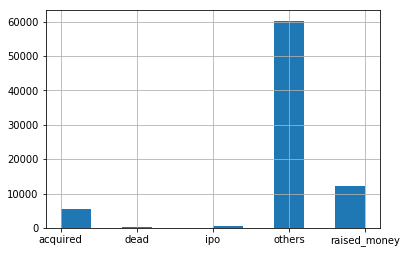

In [116]:
company_df.y.hist()

## build a KNN using startup category as the only feature

In [120]:
company_mvp_df = company_df[['category_code', 'y']]

In [130]:
company_mvp_df2 = pd.concat([company_mvp_df[company_mvp_df.y == 'others'].sample(frac=1/6),
                             company_mvp_df[company_mvp_df.y != 'others']],
                            axis=0)

In [134]:
company_mvp_df3 = pd.concat([pd.get_dummies(company_mvp_df2.category_code),
                             company_mvp_df2.y],
                            axis=1)

In [149]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
X = company_mvp_df3.iloc[:,:-1]
y = company_mvp_df3.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y)

KNN = KNeighborsClassifier()
KNN.fit(X_train, y_train)
print("The MVP has an accuracy of {:.4f}".format(KNN.score(X_test, y_test)))

The MVP has an accuracy of 0.4623
